In [1]:
import pandas as pd
import numpy as np 
from functools import reduce
from sklearn.dummy import DummyRegressor
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats #libraries for plotting 
from scipy import signal



import warnings
warnings.filterwarnings(action='ignore')

### 2.1 Import data from CSV into pandas dataframe

In [2]:
pdata = pd.read_csv("./Programming_Part1_TTI_Challenge.csv", sep='\t')

In [3]:
stats = pd.DataFrame(pdata.iloc[:,2:].describe())## gather stastics for last two columns
gm = lambda n: reduce(lambda x,y: x*y, n) ** (1.0 / len(n)) ## Function to calculate geometric mean
stats.loc[8] = [gm(pdata.X) , gm(pdata.Y)]

In [4]:
pdata.head()

,Class,PartNo,X,Y
0,AAA,X135,0.21,1.124
1,AAA,X126,0.21,1.179
2,EBHA,X195,0.32,1.191
3,EBHA,X194,0.82,1.249
4,AAA,X139,0.81,1.255


### 2.2 Print all data stastics in one table 

In [5]:
stats.rename(index={8: 'geo.mean'}) ## Last row for geometric mean 

,X,Y
count,100.000000,100.000000
mean,5.499100,3.525130
std,2.672921,1.734591
min,0.210000,1.124000
25%,3.515000,2.086250
50%,5.310000,2.974000
75%,7.810000,4.919500
max,10.020000,7.498000
geo.mean,4.495324,3.108310


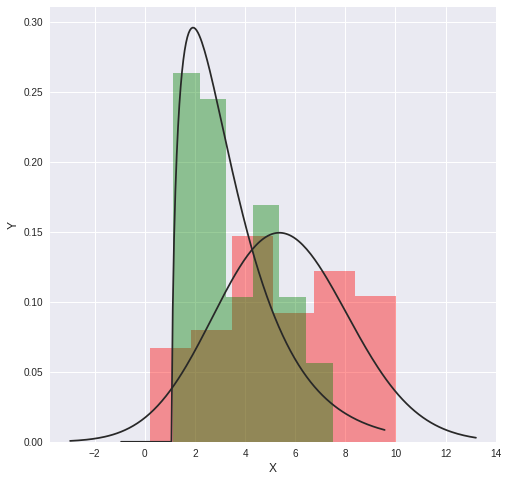

In [6]:

from scipy import stats

%matplotlib inline
plt.figure(figsize=(8,8)) #set size
sns.distplot((pdata.X),color="red", label="X" ,kde=False, fit=stats.gamma) #try to approximate a distribution over data with fit()
sns.distplot((pdata.Y),color="green",label="Y", kde=False, fit=stats.gamma)

plt.ylabel('Y', fontsize=12)
plt.xlabel("X", fontsize=12)
plt.show()

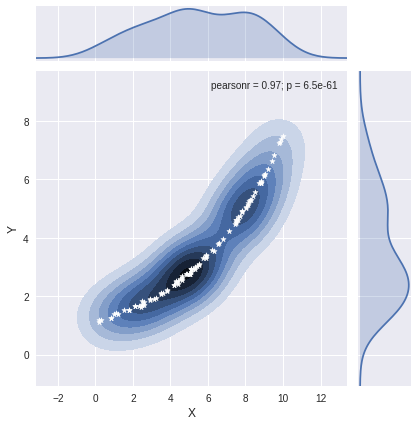

In [7]:
plt.figure(figsize=(14,10)) #set size
g = sns.jointplot(x="X", y="Y", data=pdata, kind="kde"); ## use KDE method to get more idea about the data
g.plot_joint(plt.scatter, c="w", s=30, linewidth=.5, marker="*") ## plot a line in data with all the data points
g.ax_joint.collections[0].set_alpha(0)

plt.ylabel('Y', fontsize=12)
plt.xlabel("X", fontsize=12)
plt.show()

#### From the plots we can see that the two features are highly correlated and form a clear function curve. 

#### 2.3 To write out data to a table, it can be done in many ways but for this exercise I am sqlite db since it is a lightweight and minimal to setup. The connection part can be replace with any database details/jdbc connections, such as Oracle or MySQL.



In [8]:
import sqlite3
conn = sqlite3.connect("new.db")
pdata.to_sql("p1", conn, if_exists="replace")


#### The code also demonstrate that we can convert the data into a RDBMS table and fetch it back.

In [9]:
cur = conn.cursor()
cur.execute("select * from p1 limit 5;")
results = cur.fetchall()
print(results)
conn.commit()
conn.close()

[(0, 'AAA', 'X135', 0.21, 1.124), (1, 'AAA', 'X126', 0.21, 1.179), (2, 'EBHA', 'X195', 0.32, 1.1909999999999998), (3, 'EBHA', 'X194', 0.82, 1.249), (4, 'AAA', 'X139', 0.81, 1.255)]


#### We can convert the Class feature to a categorical one. 

In [10]:
pdata.nunique() #find number of unique categories
pdata.Class.value_counts()

EBHA    41
AAA     38
EBGB    21
Name: Class, dtype: int64

In [11]:
pdata.Class = pdata["Class"].astype("category")

In [12]:
X_cat = pd.get_dummies(pdata , columns=["Class"])
X_cat.drop('Y', 1,inplace=True)

In [13]:
from sklearn.model_selection import train_test_split
X_cat.set_index("PartNo", inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X_cat, pdata["Y"], test_size=0.33, random_state=2111)

Keep 2/3 of the data for training and 1/3 for testing model performance

### 2.4  Predictive Model 
### Establish a baseline with a dummy regressor, so we know that we are doing better than predicting mean. 

In [14]:
model = DummyRegressor(strategy='mean')
model.fit(X_train, y_train)
Y_pred=model.predict(X_test)
print(mean_absolute_error(y_test,Y_pred))

1.63321076436


In [15]:
X_train.head()

,X,Class_AAA,Class_EBGB,Class_EBHA
PartNo,,,,
X170,5.03,0,0,1
X107,4.81,0,1,0
X157,3.50,1,0,0
X162,7.81,0,0,1
X112,9.51,0,1,0


In [16]:
model = linear_model.LinearRegression()
model.fit(X_train.loc[:,"X"].reshape([-1,1]), y_train)

Y_pred=model.predict(X_test.loc[:,"X"].reshape([-1,1]))
print("MAE", mean_absolute_error(y_test,Y_pred))
print("R2_score", r2_score(y_test,Y_pred, multioutput='variance_weighted'))

MAE 0.38054903173
R2_score 0.935506385384


In [17]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

for i in range(2,4):
    poly = PolynomialFeatures(degree=i)
    X_ = poly.fit_transform(X_train.loc[:,"X"].reshape([-1,1]))

    predict_ = poly.fit_transform( X_test.loc[:,"X"].reshape([-1,1]) )

    clf = linear_model.LinearRegression()
    clf.fit(X_, y_train)
    y_pred = clf.predict(predict_)
    print("\n score with polynomial degree ", i)
    print("MAE     ", mean_absolute_error(y_test,y_pred))
    print("R2_score", r2_score(y_test,y_pred, multioutput='variance_weighted'))


 score with polynomial degree  2
MAE      0.0598902226937
R2_score 0.99820717458

 score with polynomial degree  3
MAE      0.0356661339162
R2_score 0.999466042223


### From plots we could see that the scatterplot has a very clear function curve, this can be leveraged by using a gradient based learner. 

In [18]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

est = GradientBoostingRegressor(n_estimators=160, learning_rate=0.09,
    max_depth=1, random_state=0, loss='ls').fit(X_train.loc[:,"X"].reshape([-1,1]), y_train)
print("MAE", mean_absolute_error(y_test, est.predict(X_test.loc[:,"X"].reshape([-1,1]))))
      
print("R2_score",r2_score(y_test,est.predict(X_test.loc[:,"X"].reshape([-1,1])), multioutput='variance_weighted'))

MAE 0.0477175234743
R2_score 0.998832727741


#### 2.5 Assess the accuracy of your predictive model

Both gradientboosting and polynomial regression models have resulted in much better performance with near perfect R2 score and low mean absolute error. 
The reason that simple linear regression did not work so well here is, the simple linear model could not generalize/model the curve function so well. Where as in case of polynomial and Boosting, since the data curve represented a polunomial/differentiable function,  at which polynomial/gradient models perform well. 

The low error means that the predictions by this model would only be off by a 0.05 of the actual values. High R2 square suggests that 99.8% of the data can be explained by the model


Also, X is the most important feature for predicting the target value. While part number has a very little contribution.

# 3 SQL Questions 
#### Write the SQL  statements to: 
1. Display Full_MFG_Name in Table B without the MFG Code ( Example: ‘Amphenol’) 
2. Calculate Total Revenue from Table B 
3. Display the top 10 Products from Table B which made highest profit 
4. Display total cost, total Price and Margins grouped by Parent_MFG in table A 
5. Display the highest selling product and the second highest selling product  
6. Display the Total Cost and Total Revenue based on Type from Table C and order it in a descending order 
7. Find which Quarter sold highest number of products 
8. Find which quarter made the highest sale in ‘AUTOMOTIVE’ category In the last year 
9. Find the Products in table C that haven’t sold 

In [19]:
s = "../MFG.txt"
conn = sqlite3.connect("new.db")

def get_dtype(s):
    import re    
    if re.match("^\d+?\.\d+?$", s) is None:
        if s.isdigit():
            return "int"
        else:
            return "string"
    return "float"

catFeatures = []
numFeatures = []

def process_dtypes(df):
    for col,x in df.iloc[1,:].iteritems():
        t = get_dtype(str(x).strip())
        if(t == "int" or t == "float" ):
            numFeatures.append(col)
            if t == "int":
                df[col] = df[col].astype(int)
            else:
                df[col] = df[col].astype(float)
        else:
            catFeatures.append(col)
            df[col] = df[col].astype(str)
    return df    

def file_to_table(fn, cols, conn=conn): #helper function to read data from a file and return a dataframe from it.
    table = []
    tname = fn.split(".")[2].strip("/")
    f = open(fn, 'r')
    for i in f:
        table.append(i.strip())
    table = np.reshape(table, [-1,cols])
    columns = table[0,:]
    data = table[1:,:]
    temp = pd.DataFrame(data, columns=columns)
    process_dtypes(temp)
    temp.to_sql(tname, conn, if_exists="replace")
    conn.commit()
    f.close()
    
    return temp

In [20]:
MFG = file_to_table('../MFG.txt',4)
conn = sqlite3.connect("new.db")

products = file_to_table('../product_table.txt',5)
conn = sqlite3.connect("new.db")

sales = file_to_table('../sales_table.txt',7)
conn = sqlite3.connect("new.db")


#### 1. Display Full_MFG_Name in Table B without the MFG Code ( Example: ‘Amphenol’) 
``` mysql
select RIGHT(a.Full_MFG_Name, LENGTH(a.Full_MFG_Name) -6) as Name , b.* from MFG a, sales_table b where a.MFG_Code = b.MFG_code;

Query #1 (Executed in 4ms)
name 	mfg_code 	product 	quantity 	unit_price 	vaunitprice1 	unit_cost 	dates
KEMET 	KEM 	N 	100 	18.43 	0.03 	13.02 	11/4/2017
KEMET 	KEM 	D 	100 	18.43 	0.03 	13.02 	21/4/2016
KEMET 	KEM 	J 	16 	3.31 	0.0001 	2.45 	26/8/2017
KEMET 	KEM 	K 	1700 	0.545 	0.072 	0.44 	6/9/2017
KEMET 	KEM 	E 	150 	0.8 	0.1666 	0.21 	4/12/2017
Amphenol 	APH 	I 	5 	15.49 	0.35 	13.8618 	15/5/2017
Amphenol 	APH 	H 	5 	16.33 	0.35 	15.2708 	19/8/2017
.
.
.
.
TE Connectivity/Raychem Tubing 	RAY 	K 	5000 	0.03 	0.0016 	0.0172 	5/2/2016

```

#### 2. Calculate Total Revenue from Table B 
#### Total revenue
``` mysql
 select sum(quantity * unit_price) as revenue from sales_table;

revenue
22595.3201681077

```

#### Total Profit  
``` mysql
select sum((quantity * unit_price) - (quantity * unit_cost)) as profit from sales_table order by profit desc LIMIT 10;
    profit
    4281.87903094292
```

#### 3. Display the top 10 Products from Table B which made highest profit

``` mysql

select product, sum((quantity * unit_price) - (quantity * unit_cost)) as profit from sales_table 
group by product 
order by profit desc LIMIT 10;


product 	profit
L 	1068.800573349
N 	540.999984741211
D 	540.999984741211
C 	470.559993743896
K 	402.499992772937
I 	339.161009788513
O 	250
E 	248.499969393015
H 	165.295968055725
F 	91.1389923095703

```


#### 4. Display total cost, total Price and Margins grouped by Parent_MFG in table A 



``` mysql
select a.Parent_MFG , sum(b.Unit_Cost) as Unit_Cost, sum(b.Unit_Price) as Unit_price, (sum( (b.quantity * b.unit_price) - (b.quantity * b.unit_cost) )/sum(b.quantity * b.unit_price) )*100 as profit_margin_pct
from MFG a, sales_table b 
where a.MFG_Code = b.MFG_code
group by a.Parent_MFG
order by a.Parent_MFG;


    Query #4 (Executed in 3ms)
    parent_mfg |	unit_cost |	unit_price |	profit_margin_pct|
    ACG | Amphenol Connector Group 	970.132 	1031.99 	9.20290857973324
    AVC | AVX Corporation 	59.7 	75.85 	14.0426265605136
    KCC | KOA Corporation 	0.75 	0.87 	13.793100967702
    KCO | Kemet Corporation 	29.14 	41.515 	28.4770947263481
    TEG | TE Connectivity Group 	112.814 	224.77 	48.3635106304724
```

#### 5.  Display the highest selling product and the second highest selling product 

```mysql

 select product,sum(quantity*unit_Cost) as sale from sales_table 
 group by product
 order by sale desc limit 2;
 
product 	sale
L 	7915.79961776733
K 	1833.99999886751


```

#### 6. Display the Total Cost and Total Revenue based on Type from Table C and order it in a descending order 

Without the nested query, the values returned would consider duplicate values (x4 times) for product K 

```mysql 
 select 
 abc.type as Type, 
 sum(abc.total_revenue) as total_revenue,
 sum(abc.total_cost) as total_cost 
 from
 (
     select 
     distinct pt.product as product,
    pt.type as type,
     (st.quantity * st.unit_price)       as total_revenue,
     (st.quantity * st.unit_cost) as total_cost
     from product_table pt
    inner join sales_table st
    on(st.product = pt.product)
  ) as abc
  group by abc.type
  order by abc.type desc;

type 	total_revenue 	total_cost
EREL 	16534.8101039827 	14065.0290335119
COMM 	4141.51003456116 	2879.95005607605
```

#### 7  Find which Quarter sold highest number of products

```mysql

select  EXTRACT(YEAR from to_date(dates,'DD/MM/YYYY')) as YEAR, EXTRACT(QUARTER from to_date(dates,'DD/MM/YYYY')) as quart, sum(quantity) as Number_of_products 
from sales_table
group by year,quart
order by Number_of_products desc LIMIT 1;

year 	quart 	number_of_products
2017 	1 	5015

```

#### 8. Find which quarter made the highest sale in ‘AUTOMOTIVE’ category In the last year 
```mysql
select stt.years, stt.Quarter_num, pt.category, sum(st.quantity * st.Unit_cost) as sale
from sales_table st , product_table pt, 
(select EXTRACT(YEAR from to_date(dates,'DD/MM/YYYY')) as years, EXTRACT(QUARTER from  to_date(dates,'DD MM YYYY')) as Quarter_num from sales_table) as stt
where st.product = pt.product 
and pt.category ='AUTOMOTIVE'
and stt.years = EXTRACT(year from CURRENT_DATE) -1 
group by stt.years, stt.Quarter_num ,pt.category
order by sale desc limit 1 ;
 
years 	quarter_num 	category 	sale
2017 	3 	AUTOMOTIVE 	10210.0002765656

```



#### 9. Find the Products in table C that haven’t sold anything ever 
```mysql
select * from product_table where product not in (select  product from sales_table);

product 	class 	commodity 	category 	type
P 	564 	C/P 	AUTOMOTIVE 	COMM
```

## Part 4

### 4.1 In Python (or Pandas) write a code to import the transaction table 

In [21]:
import pandas as pd
p3 = pd.read_excel(open("./ModelingDataSet.xlsx",'rb'))
# or using sheet index starting 0
p3.set_index("Transaction_ID", inplace=True)
p3.columns = [i.strip().lower() for i in p3.columns]

In [22]:
p3.head()

,unit_cost,quantity,extended_cost,revenue,margin%
Transaction_ID,,,,,
1,0.261167,1200,313.40,468.00,0.330341
2,1.073075,400,429.23,572.00,0.249597
3,0.109778,2880,316.16,662.88,0.523050
4,0.007200,24000,172.80,288.00,0.400000
5,0.012630,10000,126.30,320.00,0.605312


#### A quick exploratory analysis of data.

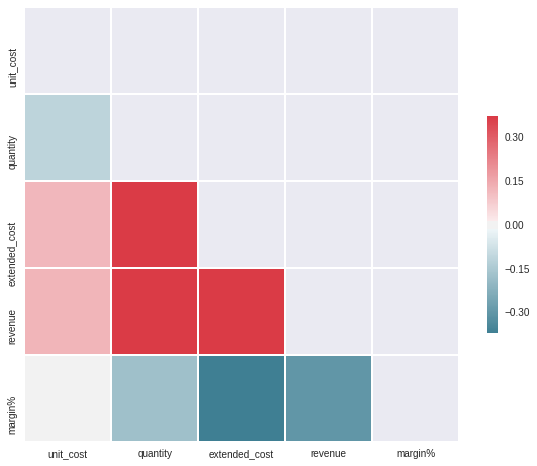

In [23]:
%matplotlib inline
sns.set(rc={'figure.figsize':(10,8)})
corr = p3.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [24]:
corr[abs(corr) > .3]

,unit_cost,quantity,extended_cost,revenue,margin%
unit_cost,1.0,NaN,NaN,NaN,NaN
quantity,NaN,1.000000,0.370578,0.391493,NaN
extended_cost,NaN,0.370578,1.000000,0.975273,-0.371363
revenue,NaN,0.391493,0.975273,1.000000,NaN
margin%,NaN,NaN,-0.371363,NaN,1.000000


#### From the correlation plot we can see that the extended_cost has very high correlation to revenue, which makes sense, higher extended cost will result in higher revenue. It also has some correlation to margin, when extended costs go up, marging goes down.


#### A Quick look at distributions of all the features

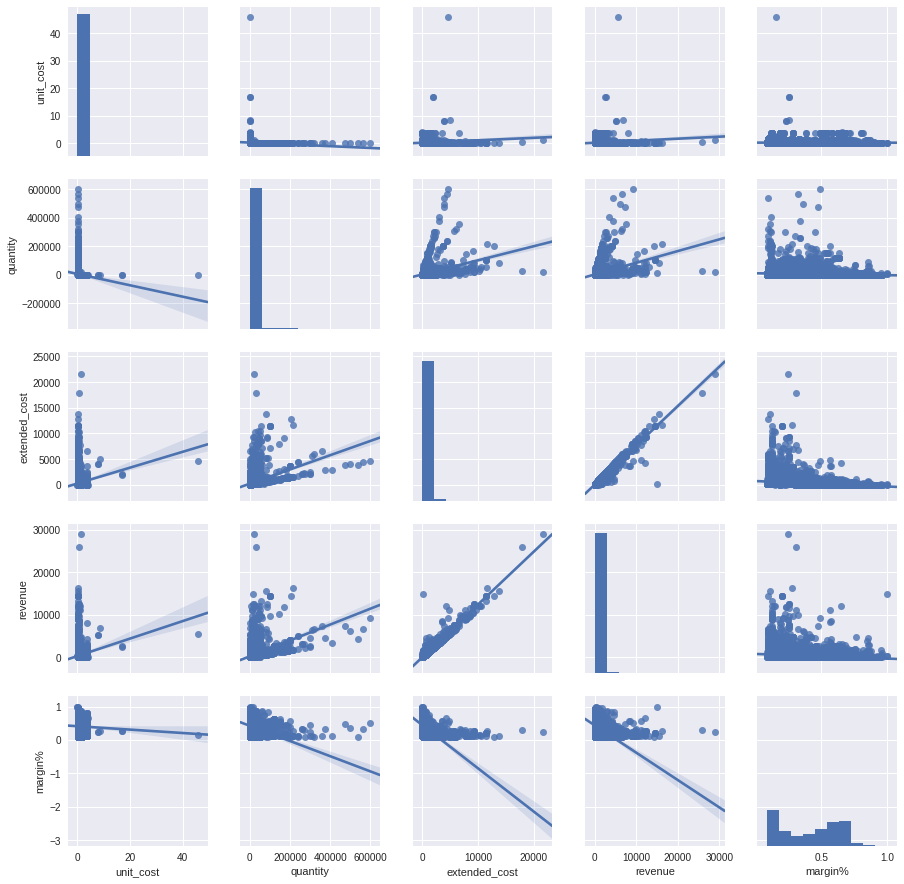

In [25]:
g = sns.pairplot(p3, kind="reg")
sns.set(rc={'figure.figsize':(8,8)})


#### From the plots we can see that the features do not follow any partucular distributions. Also many features contain extreme outlier values that coud impact our analysis. 

#### Some ireatment might be required to make this data more modelable.

#### Performing log transformation could be an option

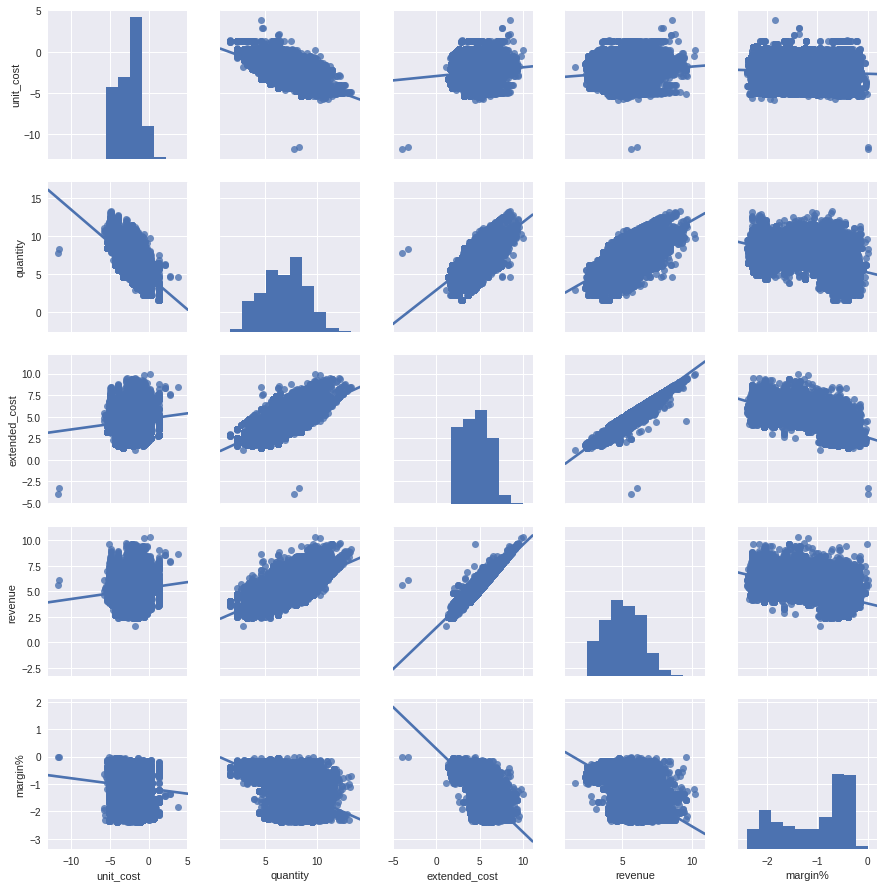

In [26]:
g = sns.pairplot(np.log(p3), kind="reg")
sns.set(rc={'figure.figsize':(8,8)})

#### Logged version of the data looks much better, we can look at the histograms can see differentiable bins now! 

#### We can also process the outliers in this data, the extreme outliers can effect the binning algorithms. Since, the algorithms will have to compensate for the variance and mean introduced by the extreme values.

#### We will test with both processes and unprocessed data.

#### Below code will remove top and bottom 1 percentile values from data and take log transformation of data and return new dataframe



In [27]:
import itertools
outliers_lst  = []

log_data = p3.copy()

# For each feature find the data points with extreme high or low values
for feature in log_data.columns:
    
    pdwn = np.percentile(log_data.loc[:, feature], 1) #values in bottom 1 percentile
    pup = np.percentile(log_data.loc[:, feature], 99) #values in upper 1 percentile
    #Using the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    
    
    step = 1.5 * (pup - pdwn)
    
    
    # The tilde sign ~ means not
    # So here, we're finding any points outside of Q1 - step and Q3 + step
    outliers_rows = log_data.loc[~((log_data[feature] >= pdwn - step) & (log_data[feature] <= pup + step)), :]
    
    print("Outliers for the feature '{}':".format(feature), len(outliers_rows[feature]))
    outliers_lst.append(list(outliers_rows.index))
outliers = list(itertools.chain.from_iterable(outliers_lst))
uniq_outliers = list(set(outliers))

# List of duplicate outliers
dup_outliers = list(set([x for x in outliers if outliers.count(x) > 1]))
print( 'Total Number of outliers:\n', len(uniq_outliers))

# Remove duplicate outliers
# Only 5 specified
processed_data = log_data.drop(log_data.index[dup_outliers]).reset_index(drop = True)
processed_data = np.log(processed_data)
# Original Data 
print( 'Original shape of data:\n', p3.shape)
# Processed Data
print( 'New shape of data:\n', processed_data.shape)

Outliers for the feature 'unit_cost': 126
Outliers for the feature 'quantity': 68
Outliers for the feature 'extended_cost': 39
Outliers for the feature 'revenue': 46
Outliers for the feature 'margin%': 0
Total Number of outliers:
 236
Original shape of data:
 (28103, 5)
New shape of data:
 (28063, 5)


### 4.2.1 In Python (or Pandas), write a code that will cluster the extended costs into bins 

### Premise for algorithms 

#### To segment data in optimal bins we can consider multiple approaches. The best thing about the data here, since we are performing 1D segmentation we can leverage the fact that data can be fully sorted and processes. (This makes k-means not so optimal approach for this problem)

#### After some research, I found some best fits for this problem , 

### The Jenks optimization method

#### https://en.wikipedia.org/wiki/Jenks_natural_breaks_optimization
Also called the Jenks natural breaks classification method, is a data clustering method designed to determine the best arrangement of values into different classes. This is done by seeking to minimize each class’s average deviation from the class mean, while maximizing each class’s deviation from the means of the other groups.

#### The optimization technique for this algorithm is exactly what we are looking for, 
#### Algorithm 
    Calculate the sum of squared deviations between classes (SDBC).
    Calculate the sum of squared deviations from the array mean (SDAM).
    Subtract the SDBC from the SDAM (SDAM-SDBC). This equals the sum of the squared deviations from the class means (SDCM).
    After inspecting each of the SDBC, a decision is made to move one unit from the class with the largest SDBC toward the class with the lowest SDBC.

Finally, the goodness of variance fit (GVF) is calculated. GVF is defined as (SDAM - SDCM) / SDAM. GVF ranges from 0 (worst fit) to 1 (perfect fit).





### CK-Means

#### reference paper https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5148156/

Fast optimal univariate clustering and segementation by dynamic programming. Three types of problem including univariate k-means, k-median, and k-segments are solved with guaranteed optimality and reproducibility. 
The core algorithm minimizes the sum of within-cluster distances using respective metrics. Its advantage over heuristic clustering algorithms in efficiency and accuracy is increasingly pronounced as the number of clusters k increases. An auxiliary function generates histograms that are adaptive to patterns in data.



### KDE methods

We can look at distribution densities, and use the maxim and minimas to create bins, or atleast to get estimates.

### KDE Method

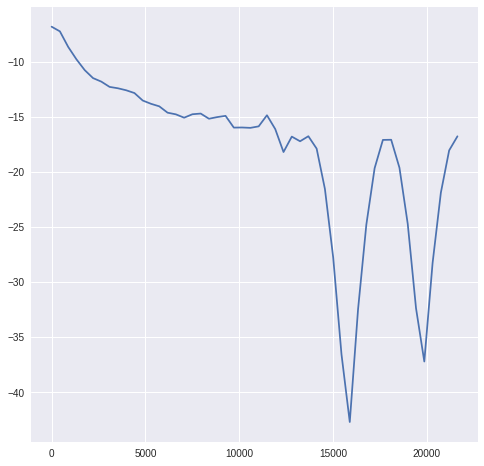

In [28]:
from numpy import array, linspace
from sklearn.neighbors.kde import KernelDensity
from matplotlib.pyplot import plot

a = p3.extended_cost.values.reshape(-1, 1)
kde = KernelDensity(kernel='gaussian', bandwidth=np.mean(p3.extended_cost)).fit(a)
s = linspace(min(p3.extended_cost),max(p3.extended_cost))
e = kde.score_samples(s.reshape(-1,1))
plot(s, e)

In [29]:
from scipy.signal import argrelextrema
mi, ma = argrelextrema(e, np.less)[0], argrelextrema(e, np.greater)[0]
print("Minima:", s[mi]) # get minimas in densities  for creating breaks
print( "Maxima:", s[ma]) #

Minima: [  7064.21591837   8388.75265306   9713.28938776  10596.31387755
  12362.36285714  13245.38734694  15894.46081633  19868.07102041]
Maxima: [  7947.24040816   9271.77714286  10154.80163265  11479.33836735
  12803.87510204  13686.89959184  18102.02204082]


In [30]:
print("nmber of bins", len(s[mi])+2) 

nmber of bins 10


In [31]:
splits = a[a < mi[0]], a[(a >= mi[0]) * (a <= mi[1])], a[a >= mi[1]]

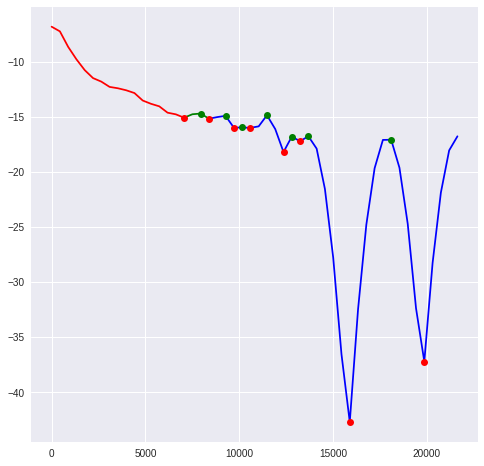

In [32]:
plot(s[:mi[0]+1], e[:mi[0]+1], 'r',
     s[mi[0]:mi[1]+1], e[mi[0]:mi[1]+1], 'g',
     s[mi[1]:], e[mi[1]:], 'b',
     s[ma], e[ma], 'go',
     s[mi], e[mi], 'ro')

### Jenks natural breaks

In [33]:
from jenks import jenks
import numpy as np
def goodness_of_variance_fit(array, classes):
    classes = jenks(array, classes)
    classified = np.array([classify(i, classes) for i in array])
    #print(classified)
    array = p3["margin%"].values
    maxz = max(classified)

    # nested list of zone indices
    zone_indices = [[idx for idx, val in enumerate(classified) if zone + 1 == val] for zone in range(maxz)]

    # Calculate the sum of squared deviations from the array mean (SDAM).
    sdam = np.sum((array - array.mean()) ** 2)

    # sorted polygon stats
    array_sort = [np.array([array[index] for index in zone]) for zone in zone_indices]

    # Calculate the sum of squared deviations between classes (SDBC).
    sdcm = sum([np.sum((classified - classified.mean()) ** 2) for classified in array_sort])

    # goodness of variance fit
    gvf = (sdam - sdcm) / sdam

    return gvf, classes

def classify(value, breaks):
    for i in range(1, len(breaks)):
        if value < breaks[i]:
            return i
    return len(breaks) - 1

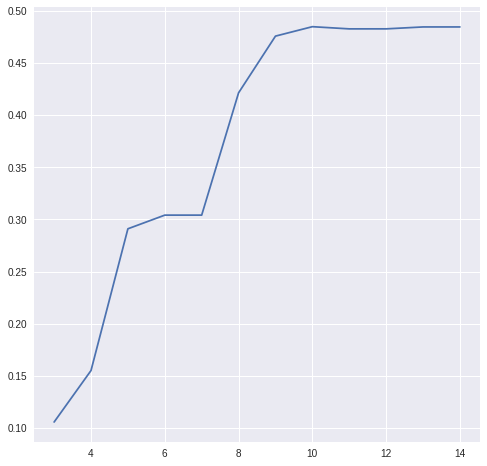

In [34]:
gvf = 0
gvfs = []
nclasses = 2
for nclasses in range(3,15):
    gvf, cls = goodness_of_variance_fit(p3["extended_cost"].values, nclasses)
    gvfs.append(gvf)

plt.plot(range(3,15), gvfs )
plt.xlabel="number_of_bins"
plt.xlabel="ratio_of_variance_to_mean_difference"
    


#### metric - variance across clusters/variance within clusters. 0 being worst fit, 1 being best fit
#### We can see that after 9-10 bins the metric does not increas much. 


### Metric

I extracted variance within cluster and average difference across clusters from data(SSW, SSB, SST)  and generated stastics for both processed and unprocessed data in vars_stats function 
#.

SSW - sum squared within cluster

SSB - sum squared between cluster means 

SST - Total variance 

For calculations I have used a ratio on variance within to variance across. This fits the problem discription well.

#### The function stat_n_bins takes in data frame, uses ckmeans, jenks and kmeans and returns statistics sorted by the metric. Optionally can also perform plotting for data. 

ex. 

stat_n_bins(range(3,12),["extended_cost", "margin%"], processed_data, lg=True)

arg 1  - bin range to traverse

arg 2 - primary and secondary feature (primary to create segments, secondary to find stats in those bins )

arg 3 - dataframe to use 

arg 4 - was a log transformed dataframe passed 

#### All the stats were calculated with data in its original shape (exp ws taken while calculating stats)


In [35]:
from sklearn.cluster import KMeans
from jenks import jenks #https://en.wikipedia.org/wiki/Jenks_natural_breaks_optimization
import ckmeans #https://journal.r-project.org/archive/2011-2/RJournal_2011-2_Wang+Song.pdf
import os
from contextlib import redirect_stdout
def vars_stats(df, method_col, feature,lg):
    if lg==True:
        df = np.exp(df)
        
    k = len(df[feature].value_counts())
    N = len(df.values)
    n = df.groupby(method_col).size()
    SSqX = sum([value**2 for value in df[feature]])
    SqX = sum(df[feature])**2
    SStotal = SSqX - (SqX/N)
    SSbetween = sum(df.groupby(by=method_col).sum()[feature]**2 /n) - (SqX/N)
    SSwithin = SStotal - SSbetween
    
    return SSwithin, SSbetween
            
def stat_n_bins(n_bins, features, df,v=False, p=False, lg=False ):
    stats = []
    for i in n_bins:
        n_bin = i
        array = df[features[0]] ##feature 

        # generate labels 
        jclasses = jenks(array, n_bin)
        kmeans = KMeans(n_clusters=n_bin, n_jobs=-1, precompute_distances=True)
        reshaped = array.values.reshape([-1,1])
        kmeans.fit(reshaped)
        y_kmeans = kmeans.predict(reshaped)
        k_classes = kmeans.labels_
        with open(os.devnull, 'w') as devnull: #supress output 
            with redirect_stdout(devnull):
                ck_classes = ckmeans.ckmeans(array,k=n_bin)[0]
        
        # add assignment column to dataframe 
        df["jclasses"] =  np.array([classify(i, jclasses) for i in array])
        df["k_classes"] =  k_classes
        df["ck_classes"] =  ck_classes
        
        #gather statistics 
        jwvar, jbvar = vars_stats(df, "jclasses", features[1],lg) #stats are based on Margin
        kwvar, kbvar = vars_stats(df, "k_classes", features[1], lg)
        ckwvar, ckbvar = vars_stats(df, "ck_classes", features[1],lg)
        
        # append stats
        stats.append([n_bin,kwvar,kbvar,"kmeans"])
        stats.append([n_bin,jwvar,jbvar, "jenk"])
        stats.append([n_bin,ckwvar,ckbvar,"ckmeans"])
        
        ## Plotting Flag, plot segments formeda for each iteration depending upon p flag
        if p==True:    
            sns.lmplot('margin%', 'extended_cost',
               data=df.sample(10000), 
               fit_reg=False, 
               hue="ck_classes",  
               scatter_kws={"marker": "D",  "s": 50})
            plt.title("extended_cost vs margin")
            plt.ylabel("extended_cost")
            #plt.xlabel("margin")
            plt.show()
        
        if v == True: #verbose flag
            print("\n Stats when number of bins is" , n_bin)

            print("\nUsing Jenks")
            print("Mean difference in margin across bins",jbvar )
            print("Total variance within bins                  ", jwvar)

            print("\nUsing K-Means")
            print("Mean difference in margin across bins", kbvar  )
            print("Total variance within bins                   ", kwvar )
            
            print("\nUsing 1D Optimal CKMeans")
            print("Mean difference in margin across bins", ckbvar  )
            print("Total variance within bins                   ", ckwbvar )
        else:
            print("."*n_bin) #progress bar
     
    # generate df of stastics 
    dstats = pd.DataFrame(stats)
    dstats.columns = ["n_bin","var_within", "var_between", "method"]
    dstats["ssb/sst"] = dstats["var_between"]/(dstats["var_between"]+dstats["var_within"])
    dstats.sort_values(by="ssb/sst",ascending=False, inplace=True)
    
    return dstats
  

In [36]:
eng_data_stats = stat_n_bins(range(3,12),["extended_cost", "margin%"], processed_data, lg=True)
orig_stats = stat_n_bins(range(3,12),["extended_cost", "margin%"], p3)

...
....
.....
......
.......
........
.........
..........
...........
...
....
.....
......
.......
........
.........
..........
...........


###  4.2.2 Show your solution when the number of bins (nb_b) from 3 to 10 and measure the accuracy

#### Some plotting on statistics, to understand the results better.
#### First two plots show 
1 variance between clusters # look for highest

2 variance within clusters, look for lowest 

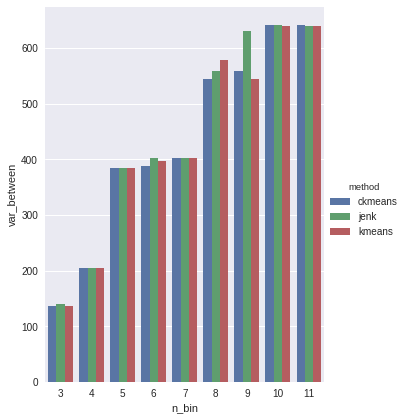

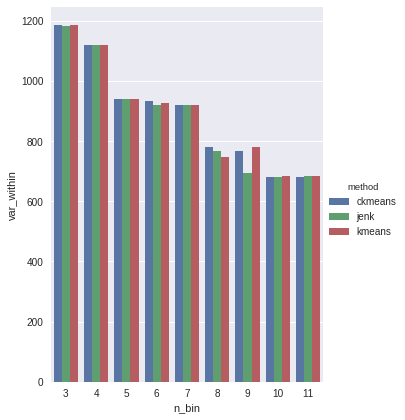

In [37]:
g = sns.factorplot(x="n_bin", y="var_between",
                    hue="method",
                   data=orig_stats, kind="bar",
                    size=6, aspect=.8);
g = sns.factorplot(x="n_bin", y="var_within",
                    hue="method",
                    data=orig_stats, kind="bar",
                    size=6, aspect=.8);

#### We can see that around 7 number of bins the ration is optimal.

Next plot shows the number of bins vs accuracy with the number of bins used. 
We can see that when original unprocessed data is used, a lower metric was achieved. but also with higher number of   bins. Reason for this lower metric could be the impact of outliers 
Extra bins were needed to accomodate outliers 


For processed data a higher accuracy was achieved (0.6) with best values around 7 bins. 


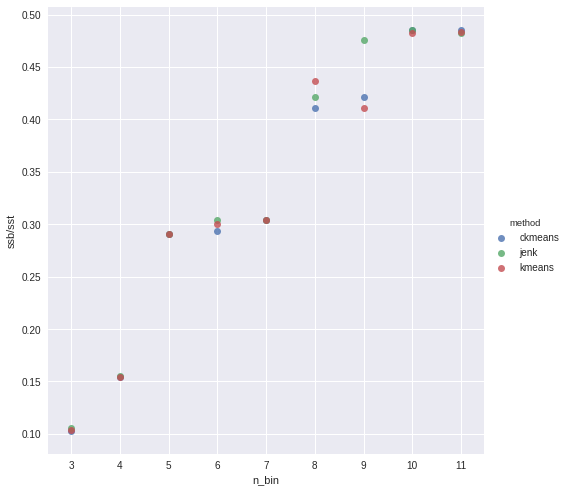

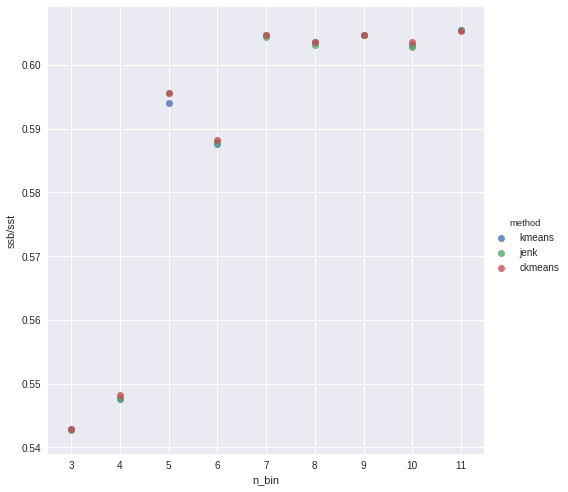

In [38]:
sns.lmplot(x="n_bin",y="ssb/sst", fit_reg=False, hue="method", data = orig_stats, size=7) #original 
sns.lmplot(x="n_bin",y="ssb/sst", fit_reg=False, hue="method", data = eng_data_stats,size=7) #processed data

### Visualizing the optimal clusters

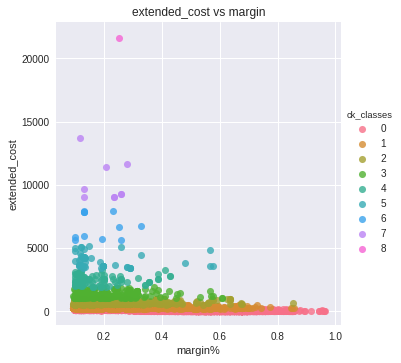

.........


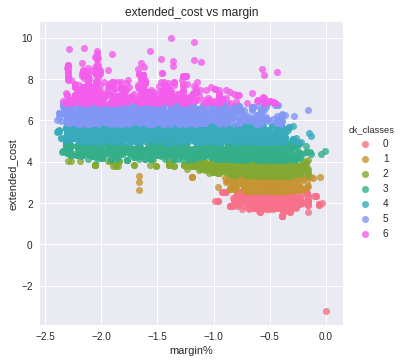

.......


,n_bin,var_within,var_between,method,ssb/sst
0,7,522.311048,799.439405,kmeans,0.604834
2,7,522.405153,799.345299,ckmeans,0.604763
1,7,522.885342,798.865110,jenk,0.604399


In [39]:
stat_n_bins(range(9,10),["extended_cost", "margin%"], p3,p=True)
stat_n_bins(range(7,8),["extended_cost", "margin%"], processed_data,p=True, lg=True)

We can see the clear clusters in transformed data(thus the reason for higher accuracy) while in unprocessed data it is a little messy since most values are in bottom. 

#### Final bins 

In [40]:
## Finally what are the actual bins?
print("Original Data")
print(ckmeans.ckmeans(p3.extended_cost,k=7)[0])
print(jenks(p3.extended_cost,7))

print("processed_data Data")
print(ckmeans.ckmeans(processed_data.extended_cost,k=7)[0])
print(jenks(processed_data.extended_cost,7))


Original Data
[  1.12951271e+08   9.46617794e+07   7.27764448e+07   7.68590259e+07
   1.19904141e+08   1.11590502e+08   7.03320014e+06]
[1 1 1 ..., 0 0 0]
[0.02, 277.89999, 800.92999, 1664.84, 3159.04, 5821.7598, 9644.0, 21634.119]
processed_data Data
[ 323.47923016  175.25828821  152.97184879  221.43465831  312.71932415
  322.52683623  481.6163363 ]
[4 5 4 ..., 0 0 4]
[-3.9120231, 2.5726123, 3.3196256, 4.0883265, 4.9035697, 5.7860379, 6.7975831, 9.9820271]


### 4.2.3  What column in the Transaction table could help you to differentiate the margins even better? 

#### Since we are aiming to segment margins and not predict them, modelling the bins does not make a lot of sense, so,  I used other columns as secondary feature to my functions above and generated statistics again. (raelier primary feature was margin, secondary was extended cost)

In [41]:
ls = ['unit_cost', 'quantity', 'revenue']
for i in ls:
    df = stat_n_bins(range(3,12),[i, "margin%"], processed_data, lg=True)
    print(df.head(2))

...
....
.....
......
.......
........
.........
..........
...........
    n_bin   var_within  var_between  method   ssb/sst
24     11  1265.205054    56.545398  kmeans  0.042781
25     11  1271.458251    50.292201    jenk  0.038050
...
....
.....
......
.......
........
.........
..........
...........
    n_bin  var_within  var_between   method   ssb/sst
18      9  816.972065   504.778387   kmeans  0.381901
26     11  818.321553   503.428900  ckmeans  0.380880
...
....
.....
......
.......
........
.........
..........
...........
    n_bin  var_within  var_between   method   ssb/sst
26     11  787.720157   534.030295  ckmeans  0.404033
24     11  788.470925   533.279527   kmeans  0.403465


In [42]:
ls = ['unit_cost', 'quantity', 'revenue']
for i in ls:
    df = stat_n_bins(range(3,12),[i, "margin%"], p3, lg=True)
    print(df.head(2))

...
....
.....
......
.......
........
.........
..........
...........
    n_bin   var_within  var_between   method   ssb/sst
26     11  3001.591316     77.52927  ckmeans  0.025179
24     11  3001.591316     77.52927   kmeans  0.025179
...
....
.....
......
.......
........
.........
..........
...........
    n_bin   var_within  var_between  method   ssb/sst
24     11  2563.960424   515.160163  kmeans  0.167308
25     11  2617.027592   462.092995    jenk  0.150073
...
....
.....
......
.......
........
.........
..........
...........
    n_bin   var_within  var_between  method   ssb/sst
24     11  2141.894487   937.226099  kmeans  0.304381
22     10  2143.538178   935.582409    jenk  0.303847




#### We can see that, none of the other features are able to return better statistics than "extended_cost", revenue comes close at .40 (last set of values) #for both original and processed data.

#### We could derive a metric from a combination of revenue and extended cost to better segment the margins.